# Investigating how a 3-2-1-0 points system might have effected the NHL

With the recent implementation of the 3-2-1-0 points system in the PWHL we remember that during the 04-05 lockout this was a heavily discussed topic. The 3-2-1-0 points system is used in international tournaments like the World Juniors and Olympics. Amongst rule changes to 3 on 3 like a touch back system or shot clock the 3-2-1-0 system is one some fans have asked for recently. It is thought that the 3-2-1-0 system incentivizes teams to win in regulation leading to more entertainment at the end of tied games as well as rewarding the "best" teams as opposed to those who are OT/shootout specialists. This notebook seeks to analyze if these notions holds true and how it might have affected past NHL seasons

THe 3-2-1-0 system awards points like this:
- Regulation win: 3 points
- Overtime/Shootout win: 2 points
- Overtime/Shootout loss: 1 point
- Regulation loss: 0 points

Versus the current system where:
- Regulation/Overtime/Shootout win : 2 points
- Overtime/Shootout loss: 1 point
- Regulation loss: 0 points

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prettytable import PrettyTable


/Users/brendanlai/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
season_of_interest = 20182019

In [3]:
game_df = pd.read_csv("data/game.csv")
team_info = pd.read_csv("data/team_info.csv")

print(f"Originally {len(game_df)} records")
game_df = game_df.drop_duplicates(subset=['game_id'])
print(f"After dropping duplicates there are: {len(game_df)} records")
game_df = game_df[game_df.type == "R"]

Originally 26305 records
After dropping duplicates there are: 23735 records


In [4]:
game_df = game_df[game_df.season == season_of_interest]
standings = team_info
standings.drop("link", axis=1, inplace=True)

# New columns to be added
standings['num_wins'] = None
standings['ploffs_def'] = None
standings['ploffs_3210'] = None

In [5]:
def assign_points_home(outcome, system):
    points_map = {
        'home win REG': {'def': 2, '3210': 3},
        'away win OT': {'def': 1, '3210': 1},
        'away win REG': {'def': 0, '3210': 0},
        'home win OT': {'def': 2, '3210': 2},
    }
    return points_map.get(outcome, {}).get(system, 0)

def assign_points_away(outcome, system):
    points_map = {
        'home win REG': {'def': 0, '3210': 0},
        'away win OT': {'def': 2, '3210': 2},
        'away win REG': {'def': 2, '3210': 3},
        'home win OT': {'def': 1, '3210': 1},
    }
    return points_map.get(outcome, {}).get(system, 0)

def compute_points(row, homeaway, pointsSys):
    outcome = row['outcome']
    is_home = homeaway == "home"


    return assign_points_home(outcome, pointsSys) if is_home else assign_points_away(outcome, pointsSys)


In [6]:
for current_id in game_df['away_team_id'].unique():
    # Filter games for the current team
    team_games = game_df[(game_df['away_team_id'] == current_id) | (game_df['home_team_id'] == current_id)].copy()

    # Calculate points using default system
    team_games['points_def'] = team_games.apply(lambda row: compute_points(row, pointsSys="def", homeaway='away' if row['away_team_id'] == current_id else 'home'), axis=1)

    # Calculate points using 3-2-1-0 system
    team_games['points_3210'] = team_games.apply(lambda row: compute_points(row, pointsSys="3210", homeaway='away' if row['away_team_id'] == current_id else 'home'), axis=1)

    # Count wins
    count_wins_home = team_games[team_games['outcome'].str.contains("home win") & (team_games['home_team_id'] == current_id)].shape[0]
    count_wins_away = team_games[team_games['outcome'].str.contains("away win") & (team_games['away_team_id'] == current_id)].shape[0]

    # Update standings in standings dictionary
    mask = standings['team_id'] == current_id
    standings.loc[mask, 'points_def'] = team_games['points_def'].sum()
    standings.loc[mask, 'points_3210'] = team_games['points_3210'].sum()
    standings.loc[mask, 'num_wins'] = count_wins_away + count_wins_home

# Drop teams not in that season
standings = standings.dropna(subset=['points_def'])

In [7]:
# Calculate league positions for both systems
standings['league_position_def'] = standings['points_def'].rank(ascending=False, method='min', na_option='top')  # 'min' assigns the minimum rank to tied values
standings = standings.sort_values(by=['league_position_def', 'num_wins'], ascending=[True, False]).reset_index(drop=True)
standings['league_position_def'] = standings.index + 1

standings['league_position_3210'] = standings['points_3210'].rank(ascending=False, method='min', na_option='top')  # 'min' assigns the minimum rank to tied values
standings = standings.sort_values(by=['league_position_3210', 'num_wins'], ascending=[True, False]).reset_index(drop=True)
standings['league_position_3210'] = standings.index + 1


/var/folders/4r/cft4fvnn6nj574npdkm_87z40000gn/T/ipykernel_27946/804349663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standings['league_position_def'] = standings['points_def'].rank(ascending=False, method='min', na_option='top')  # 'min' assigns the minimum rank to tied values


In [8]:
diff = abs(standings['league_position_def'] - standings['league_position_3210'])

# Calculate the league's biggest movers
maxDeltaEntries = standings[diff == diff.max()]
maxDeltaEntries['delta'] = maxDeltaEntries['league_position_def'] - maxDeltaEntries['league_position_3210']

# Print information about the league position changes
print("In the 2018-2019 NHL season, the 3-2-1-0 system would have affected the league positions in the following ways:")
print(f"Average league delta: {diff.mean():.2f}")
print(f"Median league delta: {diff.median()}")

# Print information about the leagues' biggest movers using PrettyTable
print("\nLeagues' biggest movers:")
table = PrettyTable()
table.field_names = ["Team Name", "League Position (Default)", "League Position (3-2-1-0)", "Position Delta"]

for _, row in maxDeltaEntries[["teamName", "league_position_def", "league_position_3210", "delta"]].iterrows():
    table.add_row(row.tolist())  # Convert each row to a list and add to the table

print(table)

In the 2018-2019 NHL season, the 3-2-1-0 system would have affected the league positions in the following ways:
Average league delta: 0.65
Median league delta: 0.0

Leagues' biggest movers:
+-------------+---------------------------+---------------------------+----------------+
|  Team Name  | League Position (Default) | League Position (3-2-1-0) | Position Delta |
+-------------+---------------------------+---------------------------+----------------+
| Maple Leafs |             8             |             6             |       2        |
|  Hurricanes |             11            |             9             |       2        |
|   Penguins  |             9             |             11            |       -2       |
|     Wild    |             21            |             19            |       2        |
|  Blackhawks |             20            |             22            |       -2       |
+-------------+---------------------------+---------------------------+----------------+


/var/folders/4r/cft4fvnn6nj574npdkm_87z40000gn/T/ipykernel_27946/3935808543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxDeltaEntries['delta'] = maxDeltaEntries['league_position_def'] - maxDeltaEntries['league_position_3210']


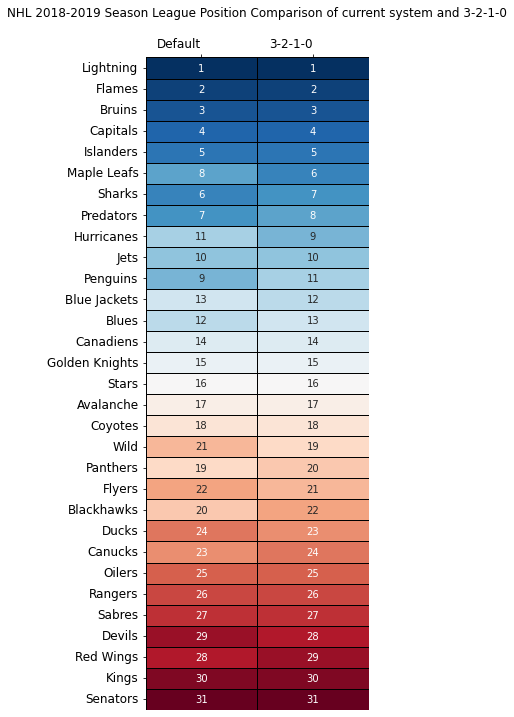

In [9]:
# League position changes

teams = standings["teamName"].tolist()

plt.figure(figsize=(4, 12))

ax = sns.heatmap(standings[["league_position_def", "league_position_3210"]], cmap='RdBu_r', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Values'}, linecolor='black')

ax.tick_params(axis='both', which='both', labelsize=12)

ax.set_yticks([i + 0.5 for i in range(len(teams))]) # y-ticks centered on bar
ax.set_yticklabels(teams, rotation=0) # y-ticks are the team names
ax.xaxis.tick_top() # Set xaxis to the top of chart
ax.collections[0].colorbar.remove() # Remove the colour bar legend

plt.title("NHL 2018-2019 Season League Position Comparison of current system and 3-2-1-0\n")
ax.set_xticklabels(["Default", "3-2-1-0"], rotation=0, ha="right")

plt.show()

In [10]:
# Divisional ranks

def assign_ranks(group, def_3210):
    if def_3210 == "def":
        group = group.sort_values(by='points_def', ascending=False)
        group['division_rank_def'] = range(1, len(group) + 1)

    elif def_3210 == "3210":
        group = group.sort_values(by='points_3210', ascending=False)
        group['division_rank_3210'] = range(1, len(group) + 1)

    return group

# Apply the function to each group within the DataFrame for both default and 3-2-1-0 system
standings = standings.groupby('division', group_keys=False).apply(assign_ranks, "def")
standings = standings.groupby('division', group_keys=False).apply(assign_ranks, "3210")

# new column 'div_rank' combining division abbreviation and rank
standings['div_rank_def'] = standings['division'] + standings['division_rank_def'].astype(str)
standings['div_rank_3210'] = standings['division'] + standings['division_rank_3210'].astype(str)

# Reset the index
standings = standings.reset_index(drop=True)

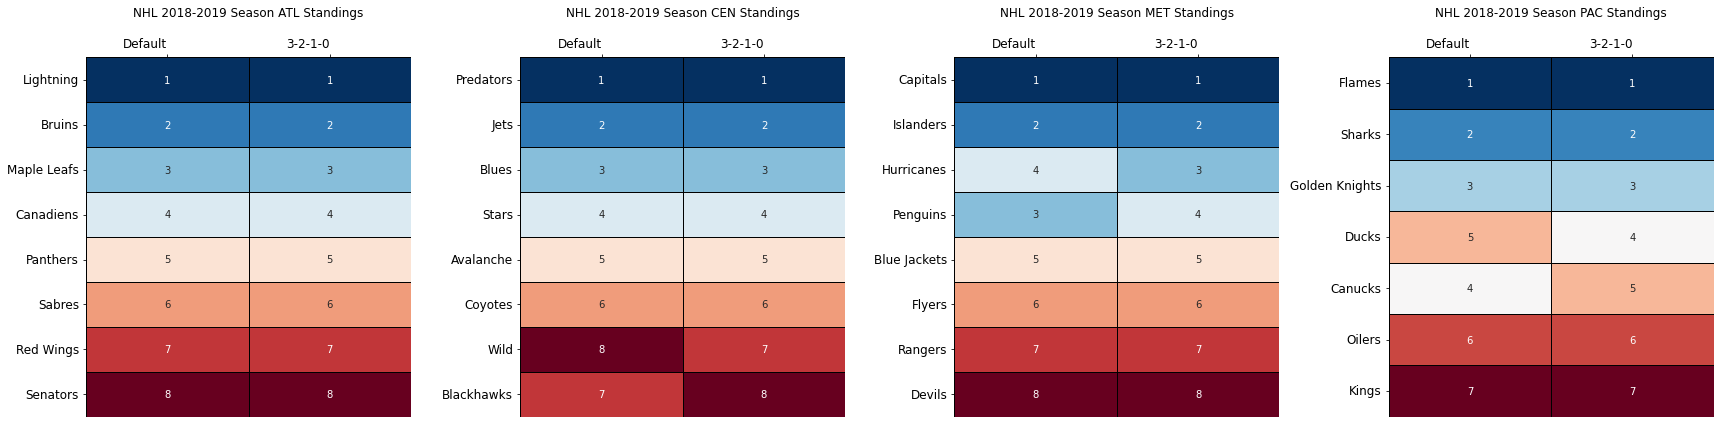

In [11]:
divisions = standings['division'].unique()

# Create subplots based on the number of divisions, arranged side by side
fig, axes = plt.subplots(ncols=len(divisions), figsize=(6 * len(divisions), 6))

# Iterate over each division
for i, division in enumerate(divisions):
    teams_df = standings[standings['division'] == division]
    teams = teams_df['teamName'].tolist()

    # Create a heatmap for each division
    ax = sns.heatmap(
        teams_df[["division_rank_def", "division_rank_3210"]],
        cmap='RdBu_r', annot=True, fmt=".0f", linewidths=.5,
        cbar_kws={'label': 'Values'}, linecolor='black', ax=axes[i]
    )

    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_yticks([i + 0.5 for i in range(len(teams))])
    ax.set_yticklabels(teams, rotation=0)
    ax.xaxis.tick_top()
    ax.collections[0].colorbar.remove()

    # Set titles and x-axis labels
    ax.set_title(f"NHL 2018-2019 Season {division} Standings\n")
    ax.set_xticklabels(["Default", "3-2-1-0"], rotation=0, ha="right")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [12]:
standings

,team_id,franchiseId,shortName,teamName,abbreviation,division,conference,num_wins,ploffs_def,ploffs_3210,points_def,points_3210,league_position_def,league_position_3210,division_rank_def,division_rank_3210,div_rank_def,div_rank_3210
0,14,31,Tampa Bay,Lightning,TBL,ATL,east,62,None,None,128.0,177.0,1,1,1,1,ATL1,ATL1
1,6,6,Boston,Bruins,BOS,ATL,east,49,None,None,107.0,145.0,3,3,2,2,ATL2,ATL2
2,10,5,Toronto,Maple Leafs,TOR,ATL,east,46,None,None,100.0,140.0,8,6,3,3,ATL3,ATL3
3,8,1,Montreal,Canadiens,MTL,ATL,east,44,None,None,96.0,133.0,14,14,4,4,ATL4,ATL4
4,13,33,Florida,Panthers,FLA,ATL,east,36,None,None,86.0,112.0,19,20,5,5,ATL5,ATL5
5,7,19,Buffalo,Sabres,BUF,ATL,east,33,None,None,76.0,97.0,27,27,6,6,ATL6,ATL6
6,17,12,Detroit,Red Wings,DET,ATL,east,32,None,None,74.0,94.0,28,29,7,7,ATL7,ATL7
7,9,30,Ottawa,Senators,OTT,ATL,east,29,None,None,64.0,87.0,31,31,8,8,ATL8,ATL8
8,18,34,Nashville,Predators,NSH,CEN,west,47,None,None,100.0,138.0,7,8,1,1,CEN1,CEN1
9,52,35,Winnipeg,Jets,WPG,CEN,west,47,None,None,99.0,137.0,10,10,2,2,CEN2,CEN2
